## Hyper Feutures

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler 
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from scipy.stats import uniform, randint

In [46]:
df_train = pd.read_csv("data/stores_train.csv")
df_test = pd.read_csv("data/stores_test.csv")
df_bus_stops = pd.read_csv("data/busstops_norway_fixed.csv")
df_grunnkrets_age_dist = pd.read_csv("data/grunnkrets_age_distribution.csv")
df_grunnkrets_house_pers = pd.read_csv("data/grunnkrets_households_num_persons.csv")
df_grunnkrets_income_house = pd.read_csv("data/grunnkrets_income_households.csv")
df_grunnkrets_stripped = pd.read_csv("data/grunnkrets_norway_stripped.csv")
df_plaace_hierarchy = pd.read_csv("data/plaace_hierarchy.csv")
df_extra = pd.read_csv("data/stores_extra.csv")

In [47]:
df_grunnkrets_stripped = df_grunnkrets_stripped[df_grunnkrets_stripped.year == 2016]
df_grunnkrets_age_dist = df_grunnkrets_age_dist[df_grunnkrets_age_dist.year == 2016]
df_grunnkrets_house_pers = df_grunnkrets_house_pers[df_grunnkrets_house_pers.year == 2016]
df_grunnkrets_income_house = df_grunnkrets_income_house[df_grunnkrets_income_house.year == 2016]

In [48]:
def rmsle(y_true, y_pred):
    """
    Computes the Root Mean Squared Logarithmic Error 
    
    Args:
        y_true (np.array): n-dimensional vector of ground-truth values 
        y_pred (np.array): n-dimensional vecotr of predicted values 
    
    Returns:
        A scalar float with the rmsle value 
    
    Note: You can alternatively use sklearn and just do: 
        `sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5`
    """
    assert (y_true >= 0).all(), 'Received negative y_true values'
    assert (y_pred >= 0).all(), 'Received negative y_pred values'
    assert y_true.shape == y_pred.shape, 'y_true and y_pred have different shapes'
    y_true_log1p = np.log1p(y_true)  # log(1 + y_true)
    y_pred_log1p = np.log1p(y_pred)  # log(1 + y_pred)
    return np.sqrt(np.mean(np.square(y_pred_log1p - y_true_log1p)))

In [49]:
def label_uniformier(array_train, array_test):
    """
    Take the unique values from the train and test part to combine it in a single array.
    Useful to fit the label encoder and don't do a mess during the transform (previously fit_transform that was confusing)
    """
    label_encoder = LabelEncoder()
    labels = np.asarray(list(array_train.unique()) + list(set(array_test.unique()) - set(array_train.unique())))
    label_encoder.fit(labels)
    return label_encoder

In [50]:
def create_population_age():
    df_grunnkrets_population = df_grunnkrets_age_dist.loc[:, ['grunnkrets_id']]
    df_grunnkrets_population['total_population'] = df_grunnkrets_age_dist.iloc[:,2:92].sum(axis=1)
    df_grunnkrets_population['youngs'] = df_grunnkrets_age_dist.iloc[:,2:20].sum(axis=1)
    df_grunnkrets_population['adults'] = df_grunnkrets_age_dist.iloc[:,21:64].sum(axis=1)
    df_grunnkrets_population['seniors'] = df_grunnkrets_age_dist.iloc[:,65:92].sum(axis=1)
    return df_grunnkrets_population

In [51]:
def create_population_repartition():
    return df_grunnkrets_house_pers[['grunnkrets_id', 'couple_children_0_to_5_years', 'couple_children_6_to_17_years', 'couple_children_18_or_above', 'couple_without_children', 'single_parent_children_0_to_5_years', 'single_parent_children_6_to_17_years', 'single_parent_children_18_or_above', 'singles']]

In [52]:
def create_income_repartition():
        return df_grunnkrets_income_house[['grunnkrets_id', 'all_households', 'singles', 'couple_without_children', 'couple_with_children', 'other_households', 'single_parent_with_children']]

In [70]:
#train
X_train = df_train.loc[:, ['grunnkrets_id', 'lat', 'lon', 'sales_channel_name', 'chain_name', 'plaace_hierarchy_id']]
X_test = df_test.loc[:, ['grunnkrets_id', 'lat', 'lon', 'sales_channel_name', 'chain_name', 'plaace_hierarchy_id']]

X_train['lat'] = X_train.lat * 11.112
X_train['lon'] = X_train.lon * 6.4757
X_test['lat'] = X_test.lat * 11.112
X_test['lon'] = X_test.lon * 6.4757


X_train = pd.merge(X_train, df_grunnkrets_stripped[['grunnkrets_id', 'area_km2']], how="left", on="grunnkrets_id")
X_test = pd.merge(X_test, df_grunnkrets_stripped[['grunnkrets_id', 'area_km2']], how="left", on="grunnkrets_id")

X_train = pd.merge(X_train, df_plaace_hierarchy[['plaace_hierarchy_id', 'lv1_desc', 'lv2_desc', 'lv3_desc', 'lv4_desc']], how='left', on='plaace_hierarchy_id')
X_test = pd.merge(X_test, df_plaace_hierarchy[['plaace_hierarchy_id', 'lv1_desc', 'lv2_desc', 'lv3_desc', 'lv4_desc']], how='left', on='plaace_hierarchy_id')

""" TEST """
X_train = pd.merge(X_train, create_population_repartition(), how='left', on='grunnkrets_id')
X_test = pd.merge(X_test, create_population_repartition(), how='left', on='grunnkrets_id')

X_train = pd.merge(X_train, create_population_age(), how='left', on='grunnkrets_id')
X_test = pd.merge(X_test, create_population_age(), how='left', on='grunnkrets_id')

X_train = pd.merge(X_train, create_income_repartition(), how='left', on='grunnkrets_id')
X_test = pd.merge(X_test, create_income_repartition(), how='left', on='grunnkrets_id')
""" TEST """

le = label_uniformier(X_train['sales_channel_name'], X_test['sales_channel_name'])
X_train['encoded_channel_name'] = le.transform(X_train['sales_channel_name'])
X_test['encoded_channel_name'] = le.transform(X_test['sales_channel_name'])

X_train['chain_name'] = X_train['chain_name'].fillna('0')
X_test['chain_name'] = X_test['chain_name'].fillna('0')

le = label_uniformier(X_train['chain_name'], X_test['chain_name'])
X_train['encoded_chain'] = le.transform(X_train['chain_name'])
X_test['encoded_chain'] = le.transform(X_test['chain_name'])

le = label_uniformier(df_plaace_hierarchy['lv3_desc'], df_plaace_hierarchy['lv3_desc'])
X_train['encoded_lv3'] = le.transform(X_train['lv3_desc'])
X_test['encoded_lv3'] = le.transform(X_test['lv3_desc'])

#le = label_uniformier(df_plaace_hierarchy['lv4_desc'], df_plaace_hierarchy['lv4_desc'])
#X_train['encoded_lv4'] = le.transform(X_train['lv4_desc'])
#X_test['encoded_lv4'] = le.transform(X_test['lv4_desc'])

X_train = X_train.drop(['sales_channel_name', 'chain_name', 'plaace_hierarchy_id', 'lv1_desc', 'lv2_desc', 'lv3_desc', 'lv4_desc'], axis=1)
X_test = X_test.drop(['sales_channel_name', 'chain_name', 'plaace_hierarchy_id', 'lv1_desc', 'lv2_desc', 'lv3_desc', 'lv4_desc'], axis=1)

X_train = X_train.apply(lambda x: x.fillna(x.mean()),axis=0)
X_test = X_test.apply(lambda x: x.fillna(x.mean()),axis=0)

scaler = StandardScaler()
X_train[X_train.columns] = scaler.fit_transform(X_train)
X_test[X_test.columns] = scaler.transform(X_test)

Y_train = df_train.loc[:, ['revenue', ]]
Y_train = scaler.fit_transform(Y_train)

In [71]:
X_train, X_train_test, Y_train, Y_train_test = train_test_split(X_train, Y_train)

### Model


### Gradient Boosting with all feutures

In [72]:
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor()
fitted_model = model.fit(X_train, np.ravel(Y_train))
Y_Pred_train = model.predict(X_train_test)

In [73]:
Y_Pred_train[Y_Pred_train<0]=0
print(f'RMSLE prediction: {rmsle(scaler.inverse_transform(Y_train_test),scaler.inverse_transform([[elmt] for elmt in Y_Pred_train])):.4f}')

RMSLE prediction: 1.1747


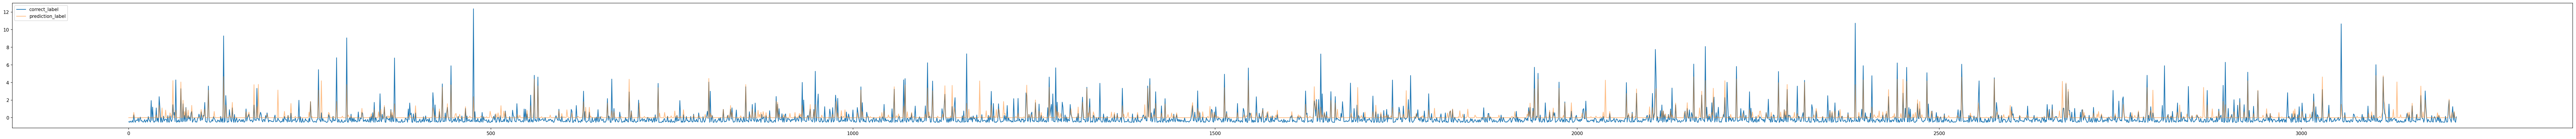

In [74]:
plt.figure(figsize=(100, 5), dpi=150)
plt.plot(range(len(Y_Pred_train)),  Y_train_test, label='correct_label')
plt.plot(range(len(Y_Pred_train)),  Y_Pred_train, label='prediction_label', alpha=0.5)
plt.legend(loc="upper left")

In [75]:
from scipy.stats import loguniform
from sklearn.ensemble import GradientBoostingRegressor

param_distributions = {
    "n_estimators": [1, 2, 5, 10, 20, 50, 100, 200, 500],
    "max_leaf_nodes": [2, 5, 10, 20, 50, 100],
    "learning_rate": loguniform(0.01, 1),
}
search_cv = RandomizedSearchCV(
    GradientBoostingRegressor(), param_distributions=param_distributions,
    scoring="neg_mean_absolute_error", n_iter=20, random_state=0, n_jobs=2
)
search_cv.fit(X_train,np.ravel(Y_train))

columns = [f"param_{name}" for name in param_distributions.keys()]
columns += ["mean_test_error", "std_test_error"]
cv_results = pd.DataFrame(search_cv.cv_results_)
cv_results["mean_test_error"] = -cv_results["mean_test_score"]
cv_results["std_test_error"] = cv_results["std_test_score"]
cv_results[columns].sort_values(by="mean_test_error")

,param_n_estimators,param_max_leaf_nodes,param_learning_rate,mean_test_error,std_test_error
12,200,50,0.110585,0.340142,0.007643
1,200,20,0.160519,0.340932,0.006752
10,200,20,0.109889,0.341125,0.005682
18,10,5,0.637819,0.360997,0.009879
4,100,5,0.0351,0.370100,0.010119
3,500,2,0.07502,0.377807,0.011223
19,5,20,0.202432,0.407974,0.010476
17,500,5,0.771785,0.413240,0.017525
9,10,5,0.088556,0.425410,0.012043
6,500,100,0.709894,0.425563,0.012935


In [76]:
error = -search_cv.score(X_train, np.ravel(Y_train))
print(f"On average, our GBDT regressor makes an error of {error:.2f} $")

On average, our GBDT regressor makes an error of 0.31 $


### Not all feutures

In [77]:
from scipy.stats import loguniform
from sklearn.ensemble import GradientBoostingRegressor

param_distributions = {
    "n_estimators": [1, 2, 5, 10, 20, 50, 100, 200, 500],
    "max_leaf_nodes": [2, 5, 10, 20, 50, 100],
    "learning_rate": loguniform(0.01, 1),
}
search_cv = RandomizedSearchCV(
    GradientBoostingRegressor(), param_distributions=param_distributions,
    scoring="neg_mean_absolute_error", n_iter=20, random_state=0, n_jobs=2
)
search_cv.fit(X_train,np.ravel(Y_train))

columns = [f"param_{name}" for name in param_distributions.keys()]
columns += ["mean_test_error", "std_test_error"]
cv_results = pd.DataFrame(search_cv.cv_results_)
cv_results["mean_test_error"] = -cv_results["mean_test_score"]
cv_results["std_test_error"] = cv_results["std_test_score"]
cv_results[columns].sort_values(by="mean_test_error")

,param_n_estimators,param_max_leaf_nodes,param_learning_rate,mean_test_error,std_test_error
12,200,50,0.110585,0.339752,0.007260
1,200,20,0.160519,0.340821,0.006543
10,200,20,0.109889,0.341612,0.006009
18,10,5,0.637819,0.360960,0.009815
4,100,5,0.0351,0.370095,0.010110
3,500,2,0.07502,0.377806,0.011223
19,5,20,0.202432,0.408006,0.010529
17,500,5,0.771785,0.410784,0.013592
9,10,5,0.088556,0.425432,0.012083
6,500,100,0.709894,0.425549,0.015269


In [78]:
error = -search_cv.score(X_train, np.ravel(Y_train))
print(f"On average, our GBDT regressor makes an error of {error:.2f} $")

On average, our GBDT regressor makes an error of 0.31 $


### Lightgbm

In [ ]:
from scipy.stats import loguniform
import lightgbm as lgb
param_distributions = {
   'learning_rate': [0.05],
    'num_leaves': [90,200],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'max_depth' : [5,6,7,8],
    'random_state' : [501], 
    'colsample_bytree' : [0.5,0.7],
    'subsample' : [0.5,0.7],
    'min_split_gain' : [0.01],
    'min_data_in_leaf':[10],
    'metric':['auc']
}
clf = lgb.LGBMRegressor()
search_cv = RandomizedSearchCV(clf
    , param_distributions=param_distributions,
    verbose=1,cv=10,n_jobs = -1,n_iter=10
)
search_cv.fit(X_train,np.ravel(Y_train))



Fitting 10 folds for each of 10 candidates, totalling 100 fits


### CatBoostRegressor
with all feutures

In [ ]:
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
model_CBR = CatBoostRegressor()
parameters = {'depth'         : [6,8,10],
                  'learning_rate' : [0.01, 0.05, 0.1],
                  'iterations'    : [30, 50, 100]
                 }

grid = GridSearchCV(estimator=model_CBR, param_grid = parameters, cv = 2, n_jobs=-1)
grid.fit(X_train, Y_train)
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n", grid.best_estimator_)
print("\n The best score across ALL searched params:\n", grid.best_score_)
print("\n The best parameters across ALL searched params:\n", grid.best_params_)

In [ ]:
model = CatBoostRegressor(depth=10,
                  learning_rate= 0.01,
                  iterations= 30)
fitted_model = model.fit(X_train, np.ravel(Y_train))
Y_Pred_train = model.predict(X_train_test)

In [ ]:
from sklearn.metrics import mean_squared_error
print(f'RMSLE prediction: {mean_squared_error(Y_train_test, Y_Pred_train)}')

In [ ]:
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
model_CBR = CatBoostRegressor()
parameters = {'depth'         : [6,8,10],
                  'learning_rate' : [0.01, 0.05, 0.1],
                  'iterations'    : [30, 50, 100]
                 }

grid = GridSearchCV(estimator=model_CBR, param_grid = parameters, cv = 2, n_jobs=-1)
grid.fit(X_train, Y_train)
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n", grid.best_estimator_)
print("\n The best score across ALL searched params:\n", grid.best_score_)
print("\n The best parameters across ALL searched params:\n", grid.best_params_)

In [ ]:
model = CatBoostRegressor(depth=10,
                  learning_rate= 0.01,
                  iterations= 30)
fitted_model = model.fit(X_train, np.ravel(Y_train))
Y_Pred_train = model.predict(X_train_test)

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X_train.columns.values.tolist(),                                                  class_names=['MEDV'], verbose=True, mode='regression')
j = 20
exp = explainer.explain_instance(X_train_test.values[j], model.predict, num_features=20)

In [ ]:
exp.show_in_notebook(show_table=True)

In [ ]:
from sklearn.metrics import mean_squared_error
print(f'RMSLE prediction: {mean_squared_error(Y_train_test, Y_Pred_train)}')

### AdaBoostRegressor
with all features

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostRegressor
from sklearn_evaluation import plot
ab_clf = AdaBoostRegressor()
parameters = {
    'n_estimators': [250,300,500],
    'learning_rate' : [0.01, 0.009],
     'loss' : ['linear', 'square']
}
grid = GridSearchCV(ab_clf, parameters, cv=5, verbose=1, n_jobs=10)
grid.fit(X_train, np.ravel(Y_train))
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n", grid.best_estimator_)
print("\n The best score across ALL searched params:\n", grid.best_score_)
print("\n The best parameters across ALL searched params:\n", grid.best_params_)
#plot_grid_search(clf)
#table_grid_search(clf)

In [ ]:
import lime
import lime.lime_tabular

In [ ]:
model = AdaBoostRegressor(n_estimators = 250,
                  learning_rate= 0.01,
                  loss= 'linear')
fitted_model = model.fit(X_train, np.ravel(Y_train))
Y_Pred_train = model.predict(X_train_test)
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X_train.columns.values.tolist(),
                                                  class_names=['MEDV'], verbose=True, mode='regression')

In [ ]:
j = 5
exp = explainer.explain_instance(X_train_test.values[j], model.predict, num_features=20)

In [ ]:
exp.show_in_notebook(show_table=True)

In [ ]:
exp.as_list()

### Random Forest

In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

parameters = {'bootstrap': [True, False],
 'max_depth': [10, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000]}

rf = RandomForestRegressor()

grid = GridSearchCV(rf, parameters, cv=5, verbose=1, n_jobs=10)
grid.fit(X_train, np.ravel(Y_train))
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n", grid.best_estimator_)
print("\n The best score across ALL searched params:\n", grid.best_score_)
print("\n The best parameters across ALL searched params:\n", grid.best_params_)

Fitting 5 folds for each of 1440 candidates, totalling 7200 fits


KeyboardInterrupt: 

In [12]:
model1 = RandomForestRegressor(
    n_estimators=150,
    max_depth=None,
    min_samples_split=10,
    min_samples_leaf=2,
    min_weight_fraction_leaf=0.0,
    max_features=None,
    max_leaf_nodes=300,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=42,
    verbose=0,
    warm_start=False,
    ccp_alpha=0.0,
    max_samples=None
)

In [13]:
model2 = AdaBoostRegressor(
    n_estimators=250,
    learning_rate=0.01,
    random_state=42,
    loss = 'linear'
)

In [14]:
model3 = GradientBoostingRegressor(
    learning_rate=0.064312,
    n_estimators=1000,
    subsample=1.0, 
    min_samples_split=4, 
    min_samples_leaf=2, 
    min_weight_fraction_leaf=0.0, 
    max_depth=9, 
    min_impurity_decrease=0.0, 
    init=None, 
    random_state=42, 
    max_features=None,
    alpha=0.9,
    verbose=0,
    max_leaf_nodes=20,
    warm_start=False,
    validation_fraction=0.1,
    n_iter_no_change=None,
    tol=0.0001,
    ccp_alpha=0.0
)

In [15]:
import lightgbm as lgb
model4 = lgb.LGBMRegressor(
    num_leaves=70,
    max_depth=7, 
    random_state=42,  
    n_estimators=2000,
    min_data_in_leaf = 400,
    learning_rate=0.05
)

In [17]:
from catboost import CatBoostRegressor
model5 = CatBoostRegressor(
    learning_rate=0.01,
    depth = 10,
    iterations = 30,
    random_seed=42,
    
)

In [23]:
from sklearn.metrics import mean_squared_error
#Random Forest
model1.fit(X_train, np.ravel(Y_train))
model1_pred = model1.predict(X_train_test)
print(f'RMSLE prediction RANDOM FOREST: {mean_squared_error(Y_train_test, model1_pred)}')

#AdaBoost
model2.fit(X_train, np.ravel(Y_train))
model2_pred = model2.predict(X_train_test)
print(f'RMSLE prediction ADA BOOST: {mean_squared_error(Y_train_test, model2_pred)}')

#GradientBoost
model3.fit(X_train, np.ravel(Y_train))
model3_pred = model3.predict(X_train_test)
print(f'RMSLE prediction Gradient Boost: {mean_squared_error(Y_train_test, model3_pred)}')

#LGB
#model4.fit(X_train, np.ravel(Y_train))
#model4_pred = model4.predict(X_train_test)
#print(f'RMSLE prediction LGB: {mean_squared_error(Y_train_test, model4_pred)}')

#CatBoost
model5.fit(X_train, np.ravel(Y_train))
model5_pred = model5.predict(X_train_test)
print(f'RMSLE prediction CatBoost: {mean_squared_error(Y_train_test, model5_pred)}')

RMSLE prediction RANDOM FOREST: 0.4318092663917278
RMSLE prediction ADA BOOST: 0.5382238906674975
RMSLE prediction Gradient Boost: 0.4427078969388857
0:	learn: 0.9925458	total: 307ms	remaining: 8.89s
1:	learn: 0.9883542	total: 454ms	remaining: 6.36s
2:	learn: 0.9844573	total: 551ms	remaining: 4.95s
3:	learn: 0.9806980	total: 644ms	remaining: 4.18s
4:	learn: 0.9768060	total: 735ms	remaining: 3.67s
5:	learn: 0.9729390	total: 845ms	remaining: 3.38s
6:	learn: 0.9687251	total: 953ms	remaining: 3.13s
7:	learn: 0.9646173	total: 1.06s	remaining: 2.91s
8:	learn: 0.9608178	total: 1.17s	remaining: 2.72s
9:	learn: 0.9574512	total: 1.3s	remaining: 2.61s
10:	learn: 0.9538162	total: 1.47s	remaining: 2.54s
11:	learn: 0.9503537	total: 1.61s	remaining: 2.41s
12:	learn: 0.9470698	total: 1.74s	remaining: 2.28s
13:	learn: 0.9429770	total: 1.87s	remaining: 2.14s
14:	learn: 0.9396452	total: 1.95s	remaining: 1.95s
15:	learn: 0.9359721	total: 2.05s	remaining: 1.8s
16:	learn: 0.9327708	total: 2.2s	remaining: 1.

In [35]:
from sklearn.ensemble import VotingRegressor
#create a dictionary of our models
estimators=[('RF', model1), ('AB', model2), ('GB', model3), ('CB', model5)]
#create our voting classifier, inputting our models
ensemble = VotingRegressor(estimators)

In [36]:
#fit model to training data
ensemble.fit(X_train, np.ravel(Y_train))
#test our model on the test data
ensemble.score(X_train_test, Y_train_test)

0:	learn: 0.9925458	total: 54.8ms	remaining: 1.59s
1:	learn: 0.9883542	total: 104ms	remaining: 1.45s
2:	learn: 0.9844573	total: 154ms	remaining: 1.39s
3:	learn: 0.9806980	total: 204ms	remaining: 1.32s
4:	learn: 0.9768060	total: 254ms	remaining: 1.27s
5:	learn: 0.9729390	total: 357ms	remaining: 1.43s
6:	learn: 0.9687251	total: 429ms	remaining: 1.41s
7:	learn: 0.9646173	total: 483ms	remaining: 1.33s
8:	learn: 0.9608178	total: 542ms	remaining: 1.26s
9:	learn: 0.9574512	total: 605ms	remaining: 1.21s
10:	learn: 0.9538162	total: 696ms	remaining: 1.2s
11:	learn: 0.9503537	total: 745ms	remaining: 1.12s
12:	learn: 0.9470698	total: 795ms	remaining: 1.04s
13:	learn: 0.9429770	total: 862ms	remaining: 985ms
14:	learn: 0.9396452	total: 926ms	remaining: 926ms
15:	learn: 0.9359721	total: 974ms	remaining: 853ms
16:	learn: 0.9327708	total: 1.02s	remaining: 783ms
17:	learn: 0.9297942	total: 1.07s	remaining: 717ms
18:	learn: 0.9265296	total: 1.16s	remaining: 672ms
19:	learn: 0.9232873	total: 1.21s	remaini

0.5523566738512954

In [39]:
xt = X_train[:20]

pred1 = model1.predict(xt)
pred2 = model2.predict(xt)
pred3 = model3.predict(xt)
pred4 = model5.predict(xt)
pred5 = ensemble.predict(xt)

ValueError: Unrecognized character R in format string

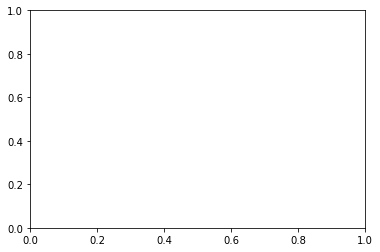

In [42]:
plt.figure()
plt.plot(pred1, 'RF', label="RandomForestRegressor")
plt.plot(pred2, "AB", label="AdaBoost")
plt.plot(pred3, "GB", label="GradientBoost")
plt.plot(pred4, "CB", label="CatBoost")
plt.plot(pred5, "VT", ms=10, label="VotingRegressor")


plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.ylabel("predicted")
plt.xlabel("training samples")
plt.legend(loc="best")
plt.title("Regressor predictions and their average")

plt.show()

In [43]:
from sklearn.ensemble import VotingRegressor
#create a dictionary of our models
estimators=[('RF', model1), ('GB', model3)]
#create our voting classifier, inputting our models
ensemble = VotingRegressor(estimators)

In [44]:
#fit model to training data
ensemble.fit(X_train, np.ravel(Y_train))
#test our model on the test data
ensemble.score(X_train_test, Y_train_test)

0.5908570963427875

In [ ]:
#LGB
model4.fit(X_train, np.ravel(Y_train))
model4_pred = model4.predict(X_train_test)
print(f'RMSLE prediction LGB: {mean_squared_error(Y_train_test, model4_pred)}')

In [55]:
from sklearn.metrics import mean_squared_error
#Random Forest
model1.fit(X_train, np.ravel(Y_train))
model1_pred = model1.predict(X_test)

#AdaBoost
model2.fit(X_train, np.ravel(Y_train))
model2_pred = model2.predict(X_test)

#GradientBoost
model3.fit(X_train, np.ravel(Y_train))
model3_pred = model3.predict(X_test)

#LGB
#model4.fit(X_train, np.ravel(Y_train))
#model4_pred = model4.predict(X_train_test)
#print(f'RMSLE prediction LGB: {mean_squared_error(Y_train_test, model4_pred)}')

#CatBoost
model5.fit(X_train, np.ravel(Y_train))
model5_pred = model5.predict(X_test)

0:	learn: 0.9886341	total: 56.7ms	remaining: 1.64s
1:	learn: 0.9842669	total: 112ms	remaining: 1.57s
2:	learn: 0.9802442	total: 175ms	remaining: 1.57s
3:	learn: 0.9763183	total: 227ms	remaining: 1.47s
4:	learn: 0.9720283	total: 291ms	remaining: 1.46s
5:	learn: 0.9679954	total: 386ms	remaining: 1.54s
6:	learn: 0.9638833	total: 455ms	remaining: 1.49s
7:	learn: 0.9595801	total: 605ms	remaining: 1.66s
8:	learn: 0.9556209	total: 747ms	remaining: 1.74s
9:	learn: 0.9519616	total: 917ms	remaining: 1.83s
10:	learn: 0.9482144	total: 1.04s	remaining: 1.8s
11:	learn: 0.9442398	total: 1.13s	remaining: 1.69s
12:	learn: 0.9408295	total: 1.29s	remaining: 1.68s
13:	learn: 0.9366754	total: 1.46s	remaining: 1.67s
14:	learn: 0.9330441	total: 1.6s	remaining: 1.6s
15:	learn: 0.9292713	total: 1.73s	remaining: 1.51s
16:	learn: 0.9258054	total: 1.83s	remaining: 1.4s
17:	learn: 0.9221299	total: 1.88s	remaining: 1.25s
18:	learn: 0.9188171	total: 1.93s	remaining: 1.12s
19:	learn: 0.9155080	total: 2.01s	remaining:

In [56]:
from sklearn.ensemble import VotingRegressor
#create a dictionary of our models
estimators=[('RF', model1), ('AB', model2), ('GB', model3), ('CB', model5)]
#create our voting classifier, inputting our models
ensemble = VotingRegressor(estimators)

In [57]:
#fit model to training data
ensemble.fit(X_train, np.ravel(Y_train))

0:	learn: 0.9886341	total: 50ms	remaining: 1.45s
1:	learn: 0.9842669	total: 102ms	remaining: 1.43s
2:	learn: 0.9802442	total: 154ms	remaining: 1.39s
3:	learn: 0.9763183	total: 203ms	remaining: 1.32s
4:	learn: 0.9720283	total: 256ms	remaining: 1.28s
5:	learn: 0.9679954	total: 341ms	remaining: 1.36s
6:	learn: 0.9638833	total: 400ms	remaining: 1.31s
7:	learn: 0.9595801	total: 455ms	remaining: 1.25s
8:	learn: 0.9556209	total: 528ms	remaining: 1.23s
9:	learn: 0.9519616	total: 587ms	remaining: 1.17s
10:	learn: 0.9482144	total: 635ms	remaining: 1.1s
11:	learn: 0.9442398	total: 684ms	remaining: 1.03s
12:	learn: 0.9408295	total: 745ms	remaining: 974ms
13:	learn: 0.9366754	total: 855ms	remaining: 977ms
14:	learn: 0.9330441	total: 911ms	remaining: 911ms
15:	learn: 0.9292713	total: 1.02s	remaining: 890ms
16:	learn: 0.9258054	total: 1.36s	remaining: 1.04s
17:	learn: 0.9221299	total: 1.48s	remaining: 989ms
18:	learn: 0.9188171	total: 1.58s	remaining: 915ms
19:	learn: 0.9155080	total: 1.67s	remaining

VotingRegressor(estimators=[('RF',
                             RandomForestRegressor(max_features=None,
                                                   max_leaf_nodes=300,
                                                   min_samples_leaf=2,
                                                   min_samples_split=10,
                                                   n_estimators=150,
                                                   random_state=42)),
                            ('AB',
                             AdaBoostRegressor(learning_rate=0.01,
                                               n_estimators=250,
                                               random_state=42)),
                            ('GB',
                             GradientBoostingRegressor(learning_rate=0.064312,
                                                       max_depth=9,
                                                       max_leaf_nodes=20,
                                                    

In [60]:
avg_prediction=ensemble.predict(X_test)

In [66]:
avg_prediction

array([-0.22994433,  0.22206986, -0.01659898, ...,  0.34579935,
       -0.05925616, -0.0324474 ])

In [69]:
# Generate submission dataframe 
# NOTE: It is important that the ID and predicted values match
submission = pd.DataFrame()
submission['id'] = df_test.store_id 
submission['predicted'] = np.asarray(scaler.inverse_transform([[elmt] for elmt in avg_prediction]) - 1)
#submission['predicted'] = np.asarray(10 ** avg_prediction - 1)

# Save it to disk (`index=False` means don't save the index in the csv)
submission.to_csv('submission_full.csv', index=False)
submission

,id,predicted
0,914206820-914239427-717245,4.840917e+04
1,916789157-916823770-824309,4.318645e+11
2,913341082-977479363-2948,9.235245e+07
3,889682582-889697172-28720,1.946877e+12
4,997991699-998006945-417222,4.842646e+11
...,...,...
8572,917323003-917383529-844309,6.481666e+11
8573,917353379-917411824-845904,6.640355e+07
8574,917072302-917089248-833647,3.450468e+13
8575,916960557-916993161-829908,2.039524e+07


In [21]:
feature_dataframe = pd.DataFrame( {'features': X_train.columns.values,
    'Random Forest feature importances': model1,
    'AdaBoost feature importances': model2,
    'GradientBoostingRegressor feature importances': model3,
    'CatBoostRegressor feature importances': model4
    })

ValueError: All arrays must be of the same length